In [1]:
from Bandits2 import Bandits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.scale import FuncScale


In [2]:
def linucb_fairness(self, ind=[], max_T=500, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=20, 
                    eps=[0.25], beta=[1], q_p=[0.2], q_w=[1], wid=[1], plots=[0, 1]):
    np.random.seed(seed)
    noise = np.mean(self.rewards) * noisef
    func = {0: self.LinUCB, 1: self.LinUCB_eps_greedy, 2: self.LinUCB_cost, 3: self.LinUCB_queue, -3: self.LinUCB_queue, 4: self.LinUCB_fairbounds}
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    hp = {0: [""], 1: eps, 2: beta, 3: q_p, -3: q_w, 4: wid}
    labe = {0: "", 1: ", ε=", 2: ", β=", 3: ", q_p=", -3: ", q_w=", 4: ", w="}
    param = {0: [{"T": max_T, "steps":steps}],
             1: [{"T": max_T, "steps":steps, "eps":ep} for ep in eps],
             2: [{"T": max_T, "steps":steps, "beta":b} for b in beta],
             3: [{"T": max_T, "steps":steps, "q_p":qp, "q_w":q_w[0]} for qp in q_p],
             -3: [{"T": max_T, "steps":steps, "q_p":q_p[0], "q_w":qw} for qw in q_w],
             4: [{"T": max_T, "steps":steps, "wid":w} for w in wid]}

    x = [int(np.floor(i * max_T / steps)) for i in range(1, steps+1)]
    y = {}
    con = {}
    freq = {}
    err = {}
    errcon = {}
    FSI = {}

    for i in ind:
        y[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        con[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        freq[i] = [np.zeros((self.C, self.K)) for l in range(len(param[i]))]
        err[i] = []
        errcon[i] = []
        FSI[i] = []
            
    assert len(np.unique(x)) == steps



    # Dependent variable (Regret)
    # Run algorithms
    for i in ind:
        for l in range(len(param[i])):
            for r in range(repeats):
                y[i][l][r] += np.array(func[i](la, delta, noise, **param[i][l])[4])
                con[i][l][r] += self.run_logs[self.run_count-1]["Consistency"]
                ca = self.chosen_arms()

                # Update chosen arms
                for c in range(self.C):
                    freq[i][l][c] += ca[0][c]
    
            err[i].append(np.std(y[i][l], axis=0, ddof=1) / np.sqrt(repeats))
            errcon[i].append(np.std(con[i][l], axis=0, ddof=1) / np.sqrt(repeats))
    
            self.df = freq[i][l]/repeats
            print(func_name[i], hp[i][l], self.df)
            G = self.Gini_fairness()
            E = self.mix() + G
            FSI[i].append(E[0])
        

    # Plot
    if 0 in plots:
        plt.figure()
        for i in ind:
            for l in range(len(param[i])):
                plt.errorbar(x, np.sum(y[i][l], axis=0)/repeats*100, yerr=err[i][l], label=f"{func_name[i]}{labe[i]}{hp[i][l]}, FSI={FSI[i][l]:.3f}", 
                            linestyle='-', marker='x', markersize=2)
        plt.legend()
        plt.grid()
        plt.xlabel("Number of Iterations")
        plt.ylabel("Cumulative Regret (%)")
        plt.title("Relationship between # of iterations and cumulative regret")
        plt.show()

    # Plot 2
    def fyscale(y):
        return y**11

    def byscale(y):
        try:
            np.seterr(all="raise")  # Turn warnings into exceptions
            return y*(1/11)
        except FloatingPointError as e:
            print(f"Error: {e} for y = {y}")
            return np.nan  # Return NaN to avoid breaking the code

    if 1 in plots:
        plt.figure()
        for i in ind:
            for l in range(len(param[i])):
                plt.errorbar(x, np.sum(con[i][l], axis=0)/repeats, yerr=errcon[i][l], label=f"{func_name[i]}{labe[i]}{hp[i][l]}",
                            linestyle='-', marker='x', markersize=2)
        plt.legend()
        # plt.gca().set_yscale(FuncScale(plt.gca(), (fyscale, byscale)))
        # plt.gca().set_ylim([0.5, 1.005])
        # plt.yticks([0.7, 0.8, 0.9, 1.0], ["0.7", "0.8", "0.9", "1.0"])
        plt.grid()
        plt.xlabel("Number of Iterations")
        plt.ylabel("Consistency")
        plt.title("Relationship between # of iterations and consistency")
        plt.show()

In [3]:
A = Bandits(5, 3, -1)

## 3.0

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]


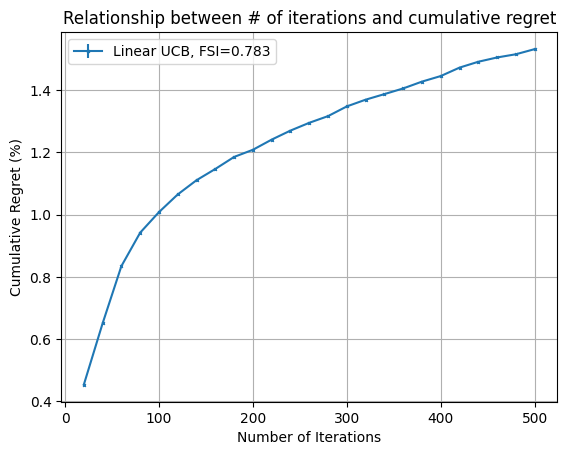

In [4]:
linucb_fairness(A, ind=[0], max_T=500, plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]


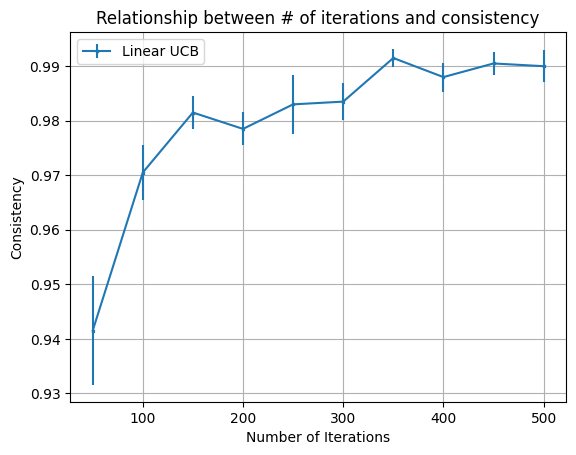

In [5]:
linucb_fairness(A, ind=[0], max_T=500, steps=10, plots=[1])

## 3.1

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
ε-greedy 0 [[0.0503 0.035  0.7869 0.0228 0.105 ]]
ε-greedy 0.5 [[0.0738 0.047  0.7174 0.0403 0.1215]]
ε-greedy 1 [[0.0895 0.066  0.6524 0.0608 0.1313]]


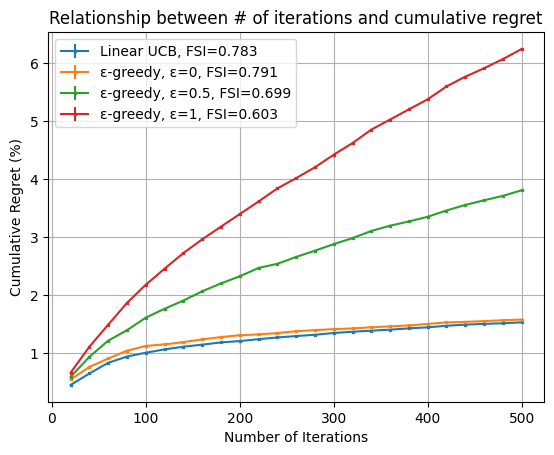

In [6]:
linucb_fairness(A, ind=[0, 1], max_T=500, eps=[0, 0.5, 1], plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
ε-greedy 0 [[0.0503 0.035  0.7869 0.0228 0.105 ]]
ε-greedy 0.5 [[0.0738 0.047  0.7174 0.0403 0.1215]]
ε-greedy 1 [[0.0895 0.066  0.6524 0.0608 0.1313]]


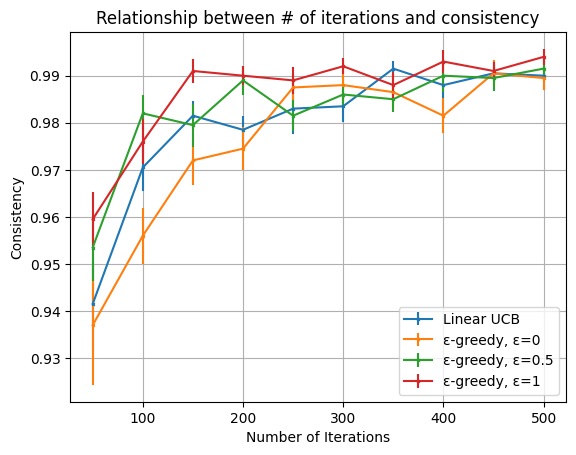

In [7]:
linucb_fairness(A, ind=[0, 1], max_T=500, steps=10, eps=[0, 0.5, 1], plots=[1])

## 3.2

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Diversity Cost 0 [[0.0594 0.0322 0.7804 0.0226 0.1054]]
Diversity Cost 0.2 [[0.0987 0.0477 0.6806 0.027  0.146 ]]
Diversity Cost 0.5 [[0.1511 0.0648 0.5785 0.04   0.1656]]


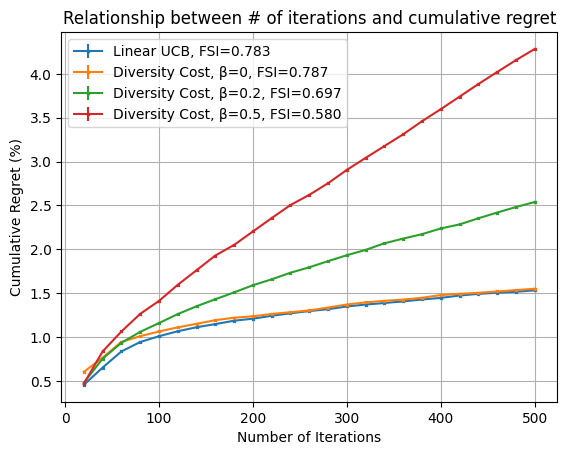

In [8]:
linucb_fairness(A, ind=[0, 2], max_T=500, beta=[0, 0.2, 0.5], plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Diversity Cost 0 [[0.0594 0.0322 0.7804 0.0226 0.1054]]
Diversity Cost 0.2 [[0.0987 0.0477 0.6806 0.027  0.146 ]]
Diversity Cost 0.5 [[0.1511 0.0648 0.5785 0.04   0.1656]]


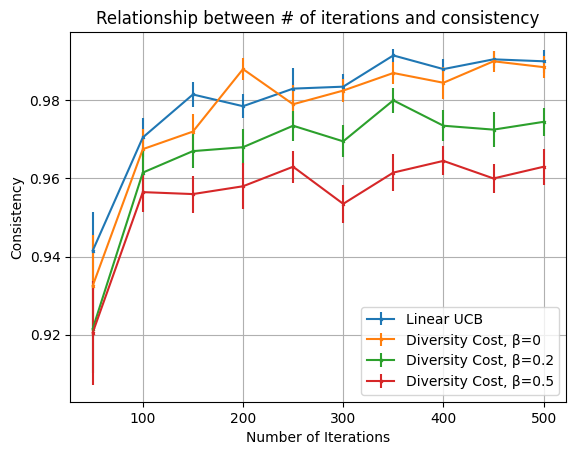

In [9]:
linucb_fairness(A, ind=[0, 2], max_T=500, steps=10, beta=[0, 0.2, 0.5], plots=[1])

## 3.3

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Queue 0 [[0.0594 0.0322 0.7804 0.0226 0.1054]]
Queue 0.5 [[0.0567 0.0485 0.7477 0.048  0.0991]]
Queue 1 [[0.0546 0.0483 0.751  0.0481 0.098 ]]
Queue 2 [[0.0616 0.049  0.7438 0.048  0.0976]]


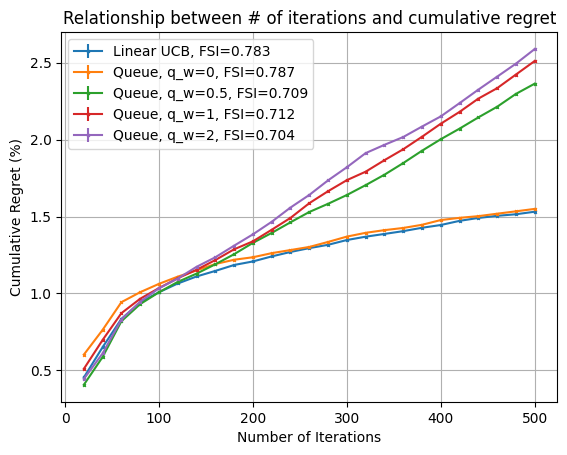

In [10]:
linucb_fairness(A, ind=[0, -3], max_T=500, q_p=[0.25], q_w=[0, 0.5, 1, 2,], plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Queue 0 [[0.0594 0.0322 0.7804 0.0226 0.1054]]
Queue 0.3 [[0.0626 0.0572 0.7256 0.0579 0.0967]]
Queue 0.5 [[0.0921 0.0911 0.6298 0.0917 0.0953]]


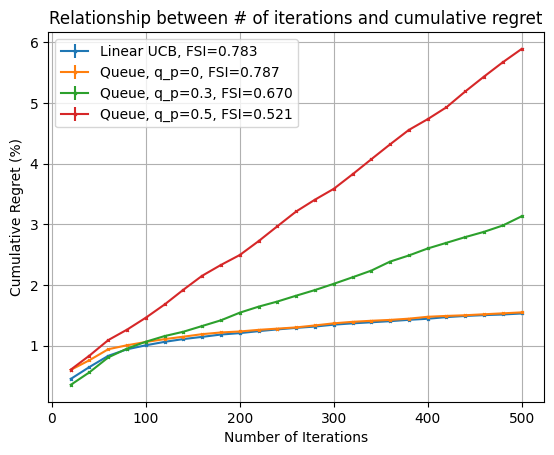

In [11]:
linucb_fairness(A, ind=[0, 3], max_T=500, q_p=[0, 0.3, 0.5], plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Queue 0 [[0.0594 0.0322 0.7804 0.0226 0.1054]]
Queue 0.3 [[0.0626 0.0572 0.7256 0.0579 0.0967]]
Queue 0.5 [[0.0921 0.0911 0.6298 0.0917 0.0953]]


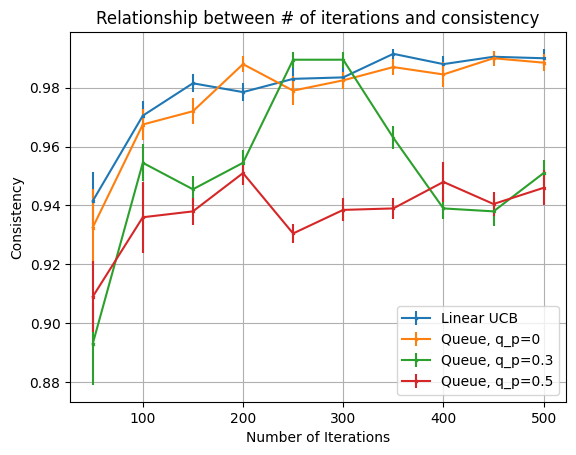

In [12]:
linucb_fairness(A, ind=[0, 3], max_T=500, steps=10, q_p=[0, 0.3, 0.5], plots=[1])

## 3.4

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Fair Bounds 0 [[0.0824 0.0733 0.678  0.083  0.0833]]
Fair Bounds 1 [[0.1159 0.1155 0.5273 0.1224 0.1189]]
Fair Bounds 2 [[0.1643 0.1594 0.3505 0.1624 0.1634]]


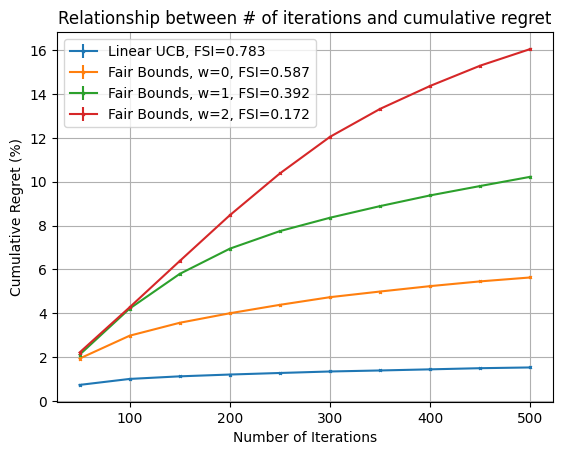

In [13]:
linucb_fairness(A, ind=[0, 4], max_T=500, steps=10, wid=[0, 1, 2], plots=[0])

Linear UCB  [[0.0569 0.0332 0.7808 0.0246 0.1045]]
Fair Bounds 0 [[0.0824 0.0733 0.678  0.083  0.0833]]
Fair Bounds 1 [[0.1159 0.1155 0.5273 0.1224 0.1189]]
Fair Bounds 2 [[0.1643 0.1594 0.3505 0.1624 0.1634]]


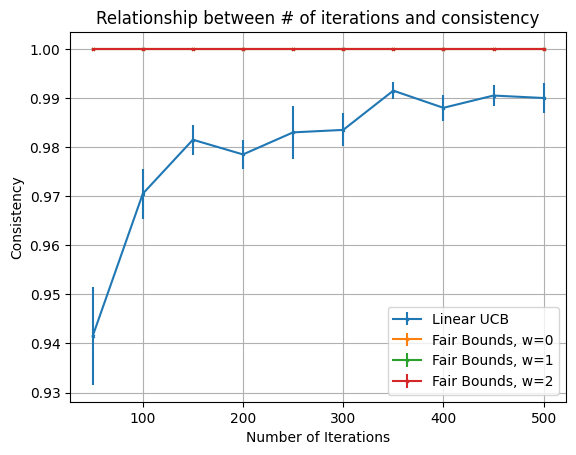

In [14]:
linucb_fairness(A, ind=[0, 4], max_T=500, steps=10, wid=[0, 1, 2], plots=[1])